#### 셀프 주유소가 정말 저렴할까?

In [38]:
import requests, time
from urllib.parse import quote
import pandas as pd
from bs4 import BeautifulSoup
import re
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from tqdm import tqdm
import folium
import math
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


##### 서울시 구별 주유소 가격 정보 얻기

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
service = Service('data/chromedriver_win32/chromedriver.exe')
driver = webdriver.Chrome(service=service)

In [3]:
url= 'https://www.opinet.co.kr/searRgSelect.do'
driver.get(url)
time.sleep(2)

In [5]:
# 서울 자치구 리스트 가져오기
metro = driver.find_element(By.XPATH,('//*[@id="SIDO_NM0"]'))                   # 광역시도
metro.send_keys('서울')

In [6]:
# 시군구
sigungu = driver.find_element(By.XPATH,'//*[@id="SIGUNGU_NM0"]')
gu_list = sigungu.find_elements(By.TAG_NAME,'option')
gu_list[1].text

'강남구'

In [7]:
gu_names = [gu.text for gu in gu_list[1:]]
gu_names[:3]

['강남구', '강동구', '강북구']

In [8]:
sigungu.send_keys(gu_names[0])

In [9]:
# 엑셀 저장
driver.find_element(By.ID,'glopopd_excel').click()
time.sleep(2)

In [10]:
# 강남구를 제외한 나머지 자치구에 대해서 주유소 정보 엑셀 저장
for gu in gu_names[1:]:
    sigungu = driver.find_element(By.XPATH,'//*[@id="SIGUNGU_NM0"]')
    gu_list = sigungu.find_elements(By.TAG_NAME,'option')
    sigungu.send_keys(gu)
    time.sleep(10)
    driver.find_element(By.ID,'glopopd_excel').click()
    time.sleep(2)


In [11]:
driver.close()

##### 구별 휘발유 가격에 대한 정리

In [19]:
from glob import glob
glob('C:/Users/YONSAI/Downloads/지역')

['C:/Users/YONSAI/Downloads/지역']

In [20]:
file = glob('C:/Users/YONSAI/Downloads/지역*.xls')[-1]
df = pd.read_excel(file,header=2)
df.head()

,지역,상호,주소,상표,전화번호,셀프여부,고급휘발유,휘발유,경유,실내등유
0,서울특별시,(주)보성 세곡주유소,서울 강남구 헌릉로 731 (세곡동),SK에너지,02-445-6870,Y,-,1653,1575,-
1,서울특별시,현대오일뱅크(주)직영 산성셀프주유소,서울 강남구 헌릉로 730,현대오일뱅크,02-2226-4963,Y,1918,1699,1595,-
2,서울특별시,현대오일뱅크 도곡셀프주유소,서울 강남구 남부순환로 2718 (도곡2동),현대오일뱅크,02-529-5101,Y,1872,1699,1654,-
3,서울특별시,자곡셀프주유소,서울 강남구 밤고개로 120 (자곡동),SK에너지,02-445-5841,Y,-,1699,1595,-
4,서울특별시,삼성동주유소,서울 강남구 테헤란로 619 (삼성동),현대오일뱅크,02-508-6572,Y,1929,1699,1609,-


In [24]:
# 25개 파일 읽어서 하나의 데이터 프레임으로 만들기
# df_result = pd.concat([,],ignore_index=True)
df_list = []
for file in glob('C:/Users/YONSAI/Downloads/지역*.xls'):
    df = pd.read_excel(file,header=2)
    df_list.append(df)

df = pd.concat(df_list,ignore_index=True)
df.shape

(441, 10)

In [25]:
df = df[['상호','주소','휘발유','셀프여부','상표']]
df.head()

,상호,주소,휘발유,셀프여부,상표
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1679,Y,현대오일뱅크
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1684,N,현대오일뱅크
2,(주)소모 신월주유소,서울 강동구 양재대로 1323 (성내동),1696,Y,GS칼텍스
3,대성석유(주)길동주유소,서울 강동구 천호대로 1168,1696,N,GS칼텍스
4,(주)삼표에너지 고덕주유소,서울 강동구 고덕로 39 (암사동),1699,Y,GS칼텍스


In [26]:
df.rename(columns={'휘발유':'가격','셀프여부':'셀프'},inplace=True)
df.head()

,상호,주소,가격,셀프,상표
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1679,Y,현대오일뱅크
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1684,N,현대오일뱅크
2,(주)소모 신월주유소,서울 강동구 양재대로 1323 (성내동),1696,Y,GS칼텍스
3,대성석유(주)길동주유소,서울 강동구 천호대로 1168,1696,N,GS칼텍스
4,(주)삼표에너지 고덕주유소,서울 강동구 고덕로 39 (암사동),1699,Y,GS칼텍스


In [27]:
df['구'] = df.주소.str.split().str[1]
df.head()

,상호,주소,가격,셀프,상표,구
0,재건에너지 재정제2주유소 고속셀프지점,서울특별시 강동구 천호대로 1246 (둔촌제2동),1679,Y,현대오일뱅크,강동구
1,구천면주유소,서울 강동구 구천면로 357 (암사동),1684,N,현대오일뱅크,강동구
2,(주)소모 신월주유소,서울 강동구 양재대로 1323 (성내동),1696,Y,GS칼텍스,강동구
3,대성석유(주)길동주유소,서울 강동구 천호대로 1168,1696,N,GS칼텍스,강동구
4,(주)삼표에너지 고덕주유소,서울 강동구 고덕로 39 (암사동),1699,Y,GS칼텍스,강동구


In [32]:
df.가격 = df.가격.astype(int)

In [34]:
df.to_csv('data/20230426_서울주유소.csv',index=False)

In [37]:
df.pivot_table('가격','셀프',aggfunc=['count','mean','max','min'])

,count,mean,max,min
,가격,가격,가격,가격
셀프,,,,
N,180,1839.305556,2690,1604
Y,261,1685.996169,2140,1589


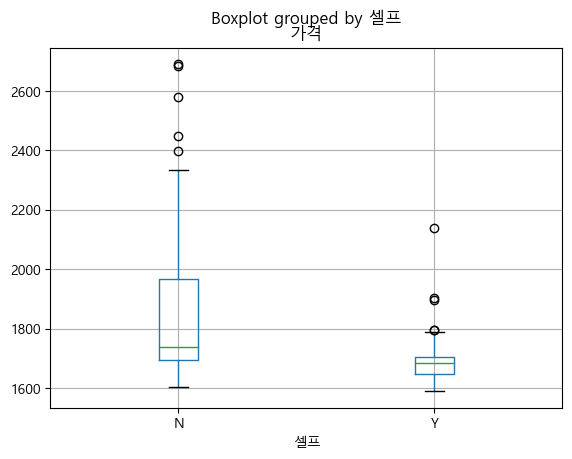

In [39]:
df.boxplot(column='가격',by='셀프');

- 가설검정(2-sample T)

In [44]:
import scipy as sp
sp.stats.ttest_ind(df[df.셀프=='Y'].가격,df[df.셀프=='N'].가격,equal_var=False)

Ttest_indResult(statistic=-9.07357050072629, pvalue=1.3292823277167452e-16)

In [45]:
# p-value가 0.05 보다 작으므로 귀무가설 기각, 즉 대립가설 채택
# 귀무가설(H0): 셀프 주유소와 일반 주유소의 가격 차이가 없다.
# 대립가설(H1): 셀프 주유소와 일반 주유소의 가격 차이가 있다.

In [47]:
# 상표별로
df.pivot_table('가격','상표','셀프',aggfunc=['count','mean','max','min'])


count               mean                  max             min        
셀프         N     Y            N            Y       N       Y       N       Y
상표                                                                          
GS칼텍스   43.0  62.0  1916.465116  1686.145161  2685.0  2140.0  1647.0  1614.0
S-OIL   25.0  54.0  1763.920000  1683.592593  2228.0  1895.0  1645.0  1618.0
SK에너지   59.0  71.0  1875.830508  1692.690141  2690.0  1797.0  1635.0  1604.0
알뜰(ex)   NaN   1.0          NaN  1589.000000     NaN  1589.0     NaN  1589.0
알뜰주유소    3.0   7.0  1666.333333  1649.142857  1738.0  1685.0  1628.0  1618.0
자가상표     2.0   NaN  1704.000000          NaN  1763.0     NaN  1645.0     NaN
현대오일뱅크  48.0  66.0  1781.000000  1686.000000  2398.0  1769.0  1604.0  1605.0

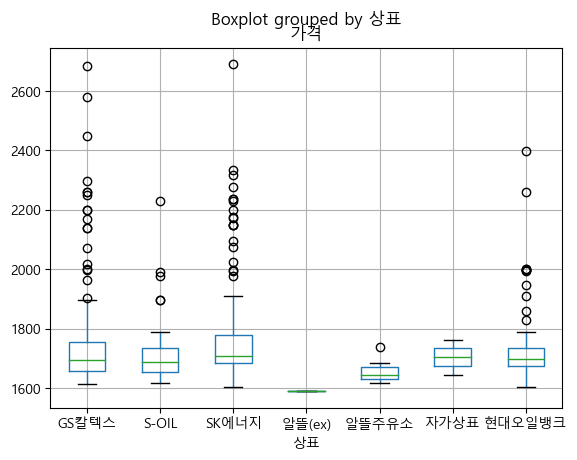

In [48]:
df.boxplot(column='가격',by='상표');


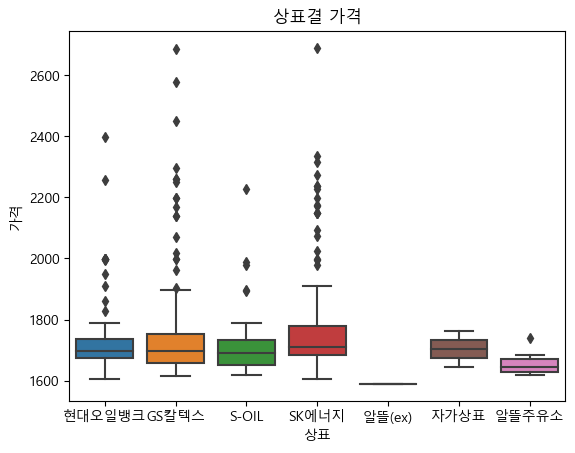

In [49]:
sns.boxplot(x='상표',y='가격',data=df)
plt.title('상표결 가격');

- 구별 가격 비교

In [52]:
df.pivot_table('가격','구',aggfunc=['count','mean','max','min']).sort_values(by=('mean','가격'),ascending=False)

,count,mean,max,min
,가격,가격,가격,가격
구,,,,
용산구,12,2148.250000,2685,1948
중구,10,2048.200000,2690,1659
종로구,9,1955.444444,2260,1669
강남구,34,1937.617647,2578,1653
성동구,16,1799.750000,2170,1645
강동구,13,1742.384615,1978,1679
관악구,14,1742.214286,1862,1685
서초구,30,1738.866667,1989,1589
